In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
import liana as li
from liana.method._pipe_utils._common import _get_props
from liana.method.sp._utils import _add_complexes_to_var
from liana._logging import _logg
from liana.method._pipe_utils import prep_check_adata, assert_covered
from scipy.sparse import csr_matrix


In [33]:
resource = li.rs.select_resource()

In [34]:
# adata = sc.read_h5ad("nanostring_cosmx_human_nsclc_batch8.h5ad")

In [35]:
adata = sc.read_h5ad("nanostring_cosmx_human_nsclc_batch8.h5ad")
li.ut.spatial_neighbors(adata=adata, bandwidth=100)
weight = adata.obsp['spatial_connectivities']

nz_prop = 0.01
x_name = 'ligand'
y_name = 'receptor'
complex_sep = '_'
xy_sep = '&'
verbose = True


def _rename_means(lr_stats, entity):
    df = lr_stats.copy()
    df.columns = df.columns.map(lambda x: entity + '_' + str(x) if x != 'gene' else 'gene')
    return df.rename(columns={'gene': entity})

if complex_sep is not None:
    adata = _add_complexes_to_var(adata,
                                    np.union1d(resource[x_name].astype(str),
                                                resource[y_name].astype(str)
                                                ),
                                    complex_sep=complex_sep
                                    )

# filter_resource
resource = resource[(np.isin(resource[x_name], adata.var_names)) &
                    (np.isin(resource[y_name], adata.var_names))]

# get entities
entities = np.union1d(np.unique(resource[x_name]),
                        np.unique(resource[y_name]))
assert_covered(entities, adata.var_names, verbose=verbose)

# Filter to only include the relevant features
adata = adata[:, np.intersect1d(entities, adata.var.index)]

xy_stats = pd.DataFrame({'means': adata.X.mean(axis=0).A.flatten(),
                        'props': _get_props(adata.X)},
                        index=adata.var_names
                        ).reset_index().rename(columns={'index': 'gene'})
# join global stats to LRs from resource
xy_stats = resource.merge(_rename_means(xy_stats, entity=x_name)).merge(
                            _rename_means(xy_stats, entity=y_name))

# filter according to props
xy_stats = xy_stats[(xy_stats[f'{x_name}_props'] >= nz_prop) &
                    (xy_stats[f'{y_name}_props'] >= nz_prop)]
if xy_stats.empty:
    raise ValueError("No features with non-zero proportions")

# create interaction column
xy_stats['interaction'] = xy_stats[x_name] + xy_sep + xy_stats[y_name]

x_mat = adata[:, xy_stats[x_name]].X
y_mat = adata[:, xy_stats[y_name]].X

In [36]:
groupby = 'cell_type'

In [37]:
celltypes = pd.get_dummies(adata.obs[groupby])
ct = csr_matrix(celltypes.astype(int).values)

In [38]:
import torch

smooth_receptors = False # NOTE: this makes it look super bad

l = torch.tensor(x_mat.toarray()).unsqueeze(1) # (n, 1, f)
s = torch.tensor(ct.toarray()).unsqueeze(2) # (n, c, 1)
w = torch.tensor(weight.toarray()) # (n, n)
ls = l * s
ls = ls.view(ls.size(0), -1)
wls = weight.dot(ls.numpy()) / weight.sum(axis=1)
# remove na
wls[np.isnan(wls)] = 0

# receptors as index for each j
if smooth_receptors:
    # NOTE: blind to cell types, will smooth surroundings
    r = (((weight @ y_mat) / weight.sum(axis=1)) > 0).astype(int).toarray()
    r[np.isnan(r)] = 0
else:
    r = (y_mat > 0).astype(int).toarray()
ri = np.tile(r, ct.shape[1])
xy_mat = np.array(wls) * ri

/var/folders/gk/kmrvz5m90sb9wftqk2n94p0h0000gq/T/ipykernel_2596/1559122303.py:10: RuntimeWarning: invalid value encountered in divide


In [39]:
var = pd.DataFrame(index=np.tile(xy_stats['interaction'], ct.shape[1]) + '&' + list(np.repeat(celltypes.columns, xy_stats.shape[0])))

In [40]:
lrdata = sc.AnnData(X=xy_mat, var=var, obs=adata.obs, uns=adata.uns, obsm=adata.obsm, varm=adata.varm, obsp=adata.obsp)

In [41]:
sc.pp.highly_variable_genes(lrdata)

In [42]:
lrdata.var[lrdata.var['highly_variable']].sort_values("means").tail(20)

,highly_variable,means,dispersions,dispersions_norm
COL18A1&KDR&tumor,True,0.476752,3.315124,0.724272
LGALS3&LAG3&tumor,True,0.530182,3.931536,1.903864
COL18A1&ITGA2_ITGB1&tumor,True,0.532326,3.377670,0.843963
HLA-DRA&CD4&myeloid,True,0.533047,3.336809,0.765769
COL6A2&ITGA2_ITGB1&tumor,True,0.553505,3.414596,0.914627
FN1&CD44&fibroblast,True,0.557173,3.202003,0.507799
VEGFA&ITGA9&tumor,True,0.568679,3.458397,0.998447
SPP1&ITGAV_ITGB1&myeloid,True,0.611449,5.319055,1.865702
SPP1&ITGAV_ITGB5&myeloid,True,0.685729,5.440094,1.979884
MIF&TNFRSF10D&tumor,True,0.687403,3.675962,0.707107


/var/folders/gk/kmrvz5m90sb9wftqk2n94p0h0000gq/T/ipykernel_2596/1150940093.py:16: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


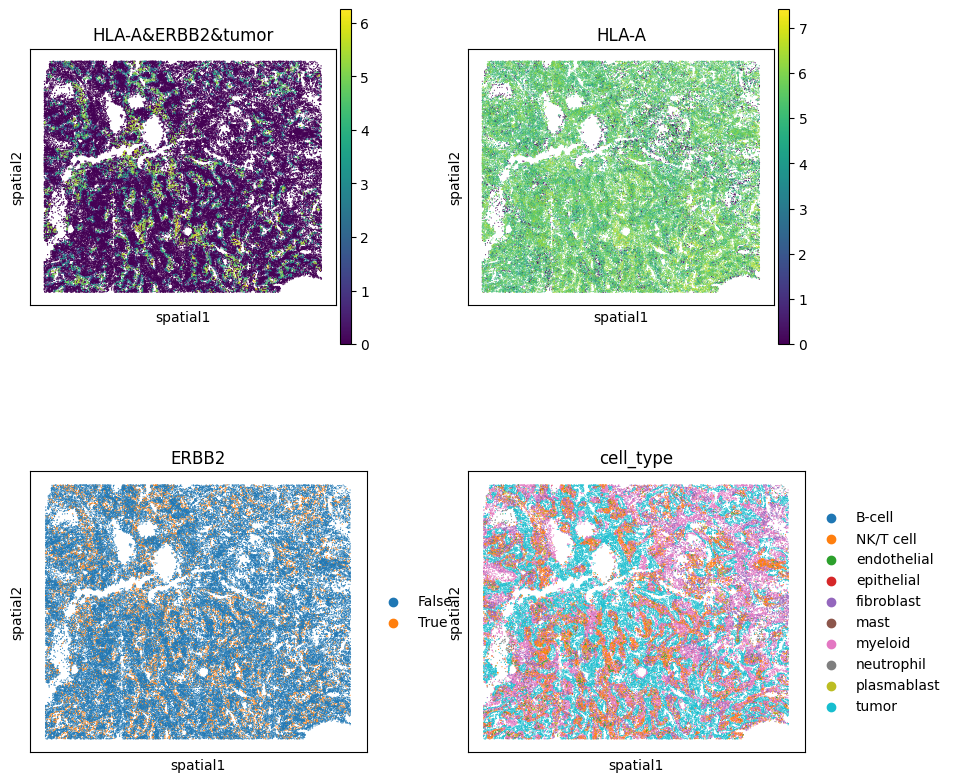

In [43]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

axes = axes.flatten()

# Define your keys
key = 'HLA-A&ERBB2&tumor'
keys = key.split('&')

if len(keys) < 2:
    raise ValueError("The 'key' variable should contain at least two elements separated by '&'.")

ligand = keys[0]
receptor = keys[1]

adata.obs['receptor'] = (adata[:, receptor].X > 0).toarray().flatten()

sc.pl.spatial(lrdata, color=[key], spot_size=100, ax=axes[0],show=False)
axes[0].set_title(f"{key}")
sc.pl.spatial(adata, color=[ligand], spot_size=80, ax=axes[1], show=False)
axes[1].set_title(f"{ligand}")
sc.pl.spatial(adata, color=['receptor'], spot_size=80, ax=axes[2], show=False)
axes[2].set_title(f"{receptor}")
sc.pl.spatial(adata, color=[groupby], spot_size=80, ax=axes[3],show=False)
axes[3].set_title(f"{groupby}")
plt.show()

In [45]:

# reshape to (n, c, f)
# wls = torch.tensor(wls).view(ls.size(0), ct.shape[1], l.size(2))


In [49]:
wls.max()

6.992662

In [60]:
wls.shape[0]

76536

In [61]:
ct.shape[1]

10

In [59]:
# reshape to (n, c, f)
x = wls.reshape(wls.shape[0], ct.shape[1], x_mat.shape[1])

ValueError: shape too large to be a matrix.

torch.Size([76536, 1, 772])

In [82]:
wsums = weight.sum(axis=0)

In [94]:
xw = x_mat.T.dot(weight) / wsums
# replace na
xw[np.isnan(xw)] = 0

/Users/b260-admin/miniforge3/envs/liana/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide


In [101]:
yi = (y_mat > 0).astype(int)